In [1]:
import pandas as pd
import plotly.express as px
import os
import numpy as np # <-- Adicionado

# Define o caminho (../ sobe um nível, de /notebooks para a raiz /ecopeak)
DATA_PATH = "../data/processed/autuacoes_processadas.parquet"

# Carrega os dados
if os.path.exists(DATA_PATH):
    df = pd.read_parquet(DATA_PATH)
    print(f"Dados carregados com sucesso! Forma: {df.shape}")
else:
    print(f"ERRO: Arquivo não encontrado em {DATA_PATH}")

# Mostra as primeiras 5 linhas
display(df.head())

Dados carregados com sucesso! Forma: (88984, 12)


,DAT_HORA_AUTO_INFRACAO,DES_INFRACAO,TP_PESSOA_INFRATOR,NUM_LATITUDE_AUTO,NUM_LONGITUDE_AUTO,distancia_uc_m,nome_uc_proxima,mes,ano,trimestre,tipo_industria,valor_multa
11,2017-04-07,Destruir ou danificar florestas ou demais form...,PJ,-10.606111,-64.732222,0.000000,RESERVA EXTRATIVISTA DO RIO OURO PRETO,4,2017,2,Fisica,376500.0
14,2017-10-04,Infração do CTF(Não Classificada-Móvel),PJ,-5.060556,-42.781667,2023.221285,PARQUE ESTADUAL ZOOBOTÃNICO,10,2017,4,Fisica,3000.0
15,2017-10-04,Infração do CTF(Não Classificada-Móvel),PJ,-5.064167,-42.783889,2473.043245,PARQUE ESTADUAL ZOOBOTÃNICO,10,2017,4,Fisica,3000.0
16,2017-10-04,Infração do CTF(Não Classificada-Móvel),PJ,-5.064444,-42.783889,2503.333620,PARQUE ESTADUAL ZOOBOTÃNICO,10,2017,4,Fisica,3000.0
17,2017-01-08,Infração da Flora(Não Classificada-Móvel),PJ,-5.064444,-42.783889,2503.333620,PARQUE ESTADUAL ZOOBOTÃNICO,1,2017,1,Fisica,5000.0


In [2]:
print("--- Informações (Tipos de Coluna e Nulos) ---")
# .info() é ótimo para ver o total de nulos e os tipos (Dtypes)
df.info()

--- Informações (Tipos de Coluna e Nulos) ---
<class 'pandas.core.frame.DataFrame'>
Index: 88984 entries, 11 to 693820
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DAT_HORA_AUTO_INFRACAO  88984 non-null  datetime64[ns]
 1   DES_INFRACAO            87326 non-null  object        
 2   TP_PESSOA_INFRATOR      88277 non-null  object        
 3   NUM_LATITUDE_AUTO       88984 non-null  float64       
 4   NUM_LONGITUDE_AUTO      88984 non-null  float64       
 5   distancia_uc_m          88976 non-null  float64       
 6   nome_uc_proxima         88976 non-null  object        
 7   mes                     88984 non-null  int32         
 8   ano                     88984 non-null  int32         
 9   trimestre               88984 non-null  int32         
 10  tipo_industria          88984 non-null  object        
 11  valor_multa             87557 non-null  float64       
dtypes: 

In [3]:
print("--- Estatísticas (Numéricas) ---")

# Seleciona as colunas de interesse
colunas_numericas = ['distancia_uc_m', 'valor_multa', 'ano']

# .describe() mostra média, mediana (50%), desvio padrão, etc.
display(df[colunas_numericas].describe())

--- Estatísticas (Numéricas) ---


,distancia_uc_m,valor_multa,ano
count,8.897600e+04,8.755700e+04,88984.000000
mean,8.547168e+04,2.999942e+05,2016.466657
std,5.057303e+05,3.146125e+06,5.301921
min,0.000000e+00,0.000000e+00,1993.000000
25%,3.000958e+03,3.000000e+03,2013.000000
50%,1.206949e+04,1.050000e+04,2017.000000
75%,3.879460e+04,9.700000e+04,2021.000000
max,8.160406e+06,5.444495e+08,2025.000000


In [4]:
print("--- 4. Criando e Analisando a Label 'Risco' ---")

def create_risk_labels(df_in):
    """Cria a variável alvo (risco) com base no valor da multa."""
    df_out = df_in.copy()
    # Preenche multas NaN com 0
    df_out['valor_multa'] = df_out['valor_multa'].fillna(0)
    
    # Define os "cortes" (quantis) para o risco
    quantiles = df_out['valor_multa'][df_out['valor_multa'] > 0].quantile([0.33, 0.66]).values
    
    def classify_risk(valor):
        if valor <= 0:
            return 'Baixo' # Multas zeradas ou não preenchidas
        elif valor <= quantiles[0]:
            return 'Baixo'
        elif valor <= quantiles[1]:
            return 'Medio'
        else:
            return 'Alto'

    df_out['risco'] = df_out['valor_multa'].apply(classify_risk)
    return df_out

# Aplica a função para criar a coluna 'risco'
df = create_risk_labels(df)

# Agora sim, podemos fazer a contagem
display(df['risco'].value_counts(normalize=True).mul(100).round(2).astype(str) + ' %')

--- 4. Criando e Analisando a Label 'Risco' ---


risco
Baixo    37.34 %
Alto     33.07 %
Medio    29.59 %
Name: proportion, dtype: object

In [5]:
print("--- 5. Criando e Analisando a Label 'Temática' (NLP) ---")

def create_topic_labels(df_in):
    """Cria labels de "temática" baseadas em palavras-chave."""
    df_out = df_in.copy()
    df_out['DES_INFRACAO'] = df_out['DES_INFRACAO'].astype(str).str.lower()
    
    def classify_topic(text):
        if 'fauna' in text or 'pesca' in text or 'animal' in text:
            return 'Fauna/Pesca'
        if 'flora' in text or 'madeira' in text or 'desmatamento' in text or 'vegetal' in text:
            return 'Flora/Desmatamento'
        if 'poluição' in text or 'poluir' in text or 'poluentes' in text:
            return 'Poluicao'
        if 'água' in text or 'rio' in text or 'recursos hídricos' in text:
            return 'Recursos Hidricos'
        return 'Outros'
        
    df_out['tematica'] = df_out['DES_INFRACAO'].apply(classify_topic)
    return df_out

# Aplica a função para criar a coluna 'tematica'
df = create_topic_labels(df)

# Agora podemos fazer a contagem
display(df['tematica'].value_counts(normalize=True).mul(100).round(2).astype(str) + ' %')

--- 5. Criando e Analisando a Label 'Temática' (NLP) ---


tematica
Outros                 41.7 %
Flora/Desmatamento    35.99 %
Fauna/Pesca           20.69 %
Recursos Hidricos      1.41 %
Poluicao               0.22 %
Name: proportion, dtype: object

--- Análise da Distância até a UC (metros) ---


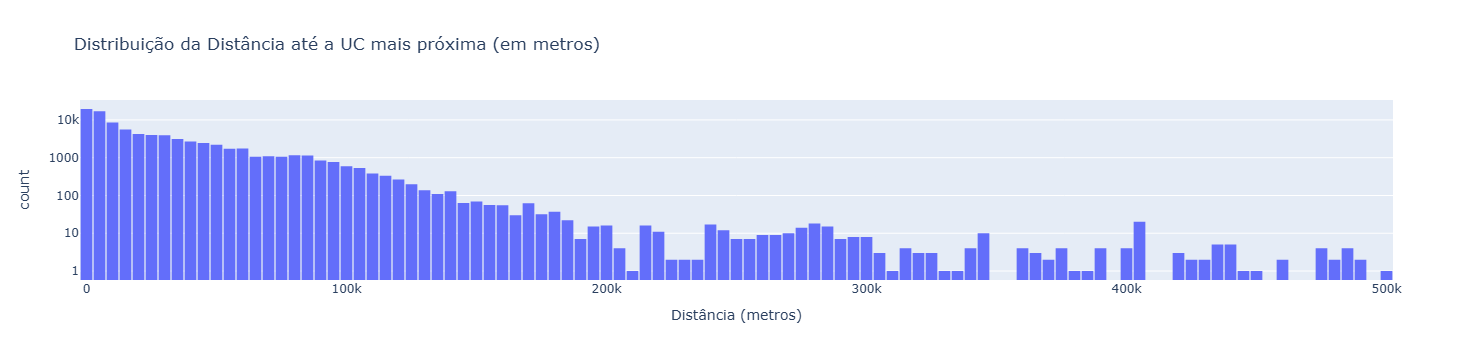

A distância média (com outliers) de uma autuação até a UC mais próxima é de: 85.47 km


In [6]:
print("--- Análise da Distância até a UC (metros) ---")

# Filtra distâncias extremas (ex: > 500km ou 500,000m) para uma melhor visualização
df_filtrado_dist = df[df['distancia_uc_m'] < 500000]

# Cria um histograma interativo com Plotly
fig_dist = px.histogram(
    df_filtrado_dist,
    x='distancia_uc_m',
    nbins=100,
    title='Distribuição da Distância até a UC mais próxima (em metros)',
    labels={'distancia_uc_m': 'Distância (metros)'},
    log_y=True # Usar escala de log no eixo Y ajuda a ver a cauda longa
)

fig_dist.update_layout(bargap=0.1)
fig_dist.show()

# Imprime a média da distância
media_distancia = df['distancia_uc_m'].mean()
print(f"A distância média (com outliers) de uma autuação até a UC mais próxima é de: {media_distancia/1000:.2f} km")

In [9]:
print("--- Verificando a coluna 'valor_multa' ---")

total_linhas = len(df)
# .info() na Célula 2 já nos disse que 'valor_multa' não tem nulos,
# porque a Célula 4 (create_risk_labels) preencheu os NaNs com 0.
# Vamos verificar quantos valores são maiores que zero.

positivos = (df['valor_multa'] > 0).sum()
zeros = (df['valor_multa'] == 0).sum()

print(f"Total de linhas: {total_linhas}")
print(f"Linhas com valor_multa > 0: {positivos}")
print(f"Linhas com valor_multa = 0: {zeros}")

--- Verificando a coluna 'valor_multa' ---
Total de linhas: 88984
Linhas com valor_multa > 0: 87372
Linhas com valor_multa = 0: 1612


--- Análise Temporal: Temática das Infrações por Ano ---


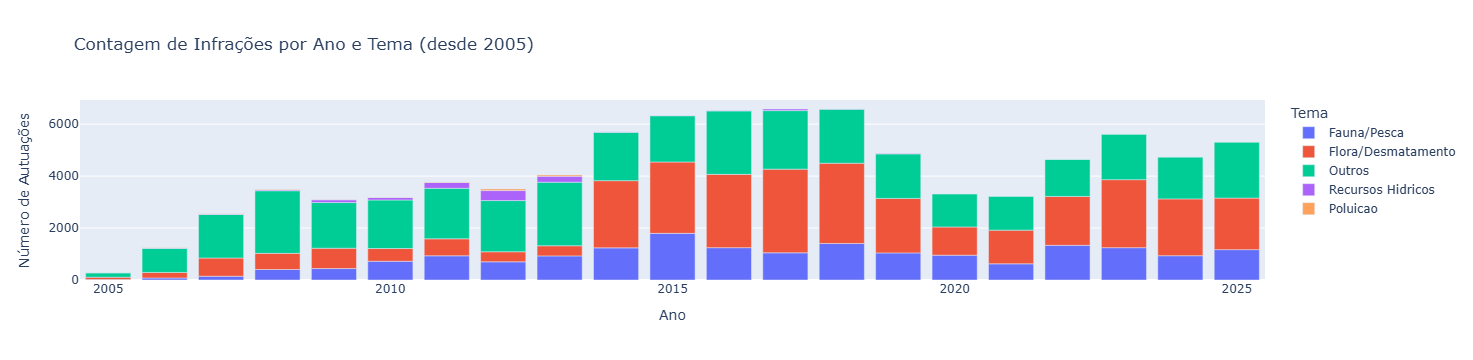

In [11]:
print("--- Análise Temporal: Temática das Infrações por Ano ---")

# Agrupa os dados por 'ano' e 'tematica' e conta as ocorrências
df_trend = df.groupby(['ano', 'tematica']).size().reset_index(name='contagem')

# Filtra anos muito antigos para uma melhor visualização (opcional)
df_trend_recente = df_trend[df_trend['ano'] >= 2005]

fig_trend = px.bar(
    df_trend_recente,
    x='ano',
    y='contagem',
    color='tematica', # Cria barras empilhadas ou agrupadas por tema
    title='Contagem de Infrações por Ano e Tema (desde 2005)',
    labels={'contagem': 'Número de Autuações', 'ano': 'Ano', 'tematica': 'Tema'}
)

fig_trend.show()